In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd

#other libraries
# from tqdm import tqdm
# import time
# import random
import os
import sys
from pathlib import Path
import h5py

#torch specific
import torch
import torchvision as torchv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Tensor
from torch.utils import data

from sklearn.model_selection import train_test_split
import wandb

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [2]:
# Importerer spaleron og micro svarte hull data

module_path = str(Path.cwd().parents[0].parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader import *
# from plotCreator import *

data_path0 = str(Path.cwd().parents[0].parents[0] / "data" / "bh" / "BH_n4_M10_res50_15000_events.h5")
data_path1 = str(Path.cwd().parents[0].parents[0] / "data" / "sph" / "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_15000_events.h5")

In [3]:
bhArray = dataToArray(data_path0)
sphArray = dataToArray(data_path1)

In [4]:
print(bhArray.shape)
print(sphArray.shape)

(15000, 50, 50, 3)
(15000, 50, 50, 3)


In [5]:
# Vi slår sammen dataene for å ha et samlet datasett som kjører gjennom modellen
dataArray = np.concatenate((bhArray,sphArray),axis=0)

In [6]:
# Labeler tabelle med 1 og 0 (0 = svart hull, 1 = spahleron)
labelsArray = np.concatenate((np.zeros(np.shape(bhArray)[0]),np.ones(np.shape(sphArray)[0])),axis=0)

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [8]:
# 75% av datasettet havner i trainData, 25% havner i testData, 
trainData, testData, trainLabels, testLabels = train_test_split(dataArray, labelsArray, random_state=42)

In [9]:
# gjør det om til en tensor fra numpy array. Vi gjør dette for at at dataene skal være lagret på GPU en istedet for en liste som er lagret på CPUen 
trainData = torch.from_numpy(trainData)
testData = torch.from_numpy(testData)
trainLabels = torch.from_numpy(trainLabels)
testLabels = torch.from_numpy(testLabels)

In [10]:
# to tensor datasett 
train = torch.utils.data.TensorDataset(trainData, trainLabels)
test = torch.utils.data.TensorDataset(testData, testLabels)

In [11]:
# Her kommer modellen inn XD 
class ConvModel(nn.Module):
    def __init__(self, dropout):

        super(ConvModel, self).__init__()
        # 2 cov lag blir opprette. Bildene har x, y og z verdi. 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=0)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=0)

        self.fc1 = nn.Linear(3*3*256, 128)
        self.fc2 = nn.Linear(128,2)

        self.dropout = nn.Dropout(dropout)



    def forward(self, x:Tensor):
        x = self.conv1(x)
        x = F.relu(x) #to activate function above

        x = F.max_pool2d(x,2)

        x = self.conv2(x)
        x = F.relu(x)

        x = F.max_pool2d(x,2)

        x = self.conv3(x)
        x = F.relu(x)

        x = F.max_pool2d(x,3)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.dropout(x)

        x = self.fc2(x)
 
        return x

In [12]:
from torchvision import models
from torchsummary import summary

model = ConvModel(0).to(device)
summary(model, (3, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             448
            Conv2d-2           [-1, 64, 22, 22]           9,280
            Conv2d-3            [-1, 256, 9, 9]         147,712
            Linear-4                  [-1, 128]         295,040
           Dropout-5                  [-1, 128]               0
            Linear-6                    [-1, 2]             258
Total params: 452,738
Trainable params: 452,738
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.68
Params size (MB): 1.73
Estimated Total Size (MB): 2.43
----------------------------------------------------------------


In [13]:
def trainFunction(config=None):

    #initialize variables
    model = ConvModel(config['dropout']).to(device)
    criterion = nn.CrossEntropyLoss()


    if config['optimizer'] is 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'])

    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=config['gamma'], last_epoch=-1)
    #initialize variables end


    #data
    trainLoader = DataLoader(train, shuffle=True, batch_size=config['batch_size'])
    testLoader = DataLoader(test, shuffle=True, batch_size=config['batch_size'])
    #data end


    wandb.watch(model, criterion, log='all')
    y_pred_out = []
    y_true_out = []

    
    #START
    for epoch in range(config['epoch']):

        #training variables
        trainRunningLoss = 0.0
        correct = 0
        y_pred = []
        y_true = []
        #training loop
        model.train()
        for i, data in enumerate(trainLoader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad() 
            output = model(inputs.permute(0,3,1,2)) # bytter på rekkefølge til dimensjonene 
            output1 = (torch.max(output.to(device), 1)[1]) # den predictede outputtn 
            y_pred.extend(output1) # Save Prediction
            
            y_true.extend(labels) # Save Truth
            loss = criterion(output, labels.type(torch.LongTensor).to(device))
            loss.backward()
            optimizer.step() # Endrer på vekten 
            
            trainRunningLoss += loss.item() * inputs.size(0) #
        #training loop end
        correct = (torch.FloatTensor(y_pred) == torch.FloatTensor(y_true)).sum()
        trainAccuracy = correct / len(y_true)
        #training variables end

        #test variables
        testRunningLoss = 0.0
        y_pred = []
        y_true = []
        #test loop
        model.eval()
        for j, data in enumerate(testLoader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs.permute(0,3,1,2))# Feed Network

            output1 = (torch.max(output.to(device), 1)[1])
            y_pred.extend(output1) # Save Prediction
            
            y_true.extend(labels) # Save Truth
            loss = criterion(output, labels.type(torch.LongTensor).to(device))
            testRunningLoss += loss.item() * inputs.size(0)
        #test loop end

        correct = (torch.FloatTensor(y_pred) == torch.FloatTensor(y_true)).sum()
        testAccuracy = correct / len(y_true)
        testRunningLoss = testRunningLoss/len(bhArray)
        trainRunningLoss = trainRunningLoss/len(bhArray)
        #test variables end

        #wandb log
        wandb.log({"Train epoch_loss":trainRunningLoss, "Test epoch_loss": testRunningLoss, "Train accuracy": trainAccuracy,"Test accuracy": testAccuracy})
        y_pred_out = y_pred
        y_true_out = y_true
        scheduler.step()

        #END
    return model, y_pred_out, y_true_out

<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\student\AppData\Local\Temp\ipykernel_12940\3189700503.py:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if config['optimizer'] is 'adam':


In [14]:
config = {
    'epoch': 10,
    'batch_size': 50,
    'gamma': 1,
    'learning_rate': 0.01,
    'optimizer': 'adam',
    'dropout': 0
}

# Pass the config dictionary when you initialize W&B
run = wandb.init(project="CNN_run", config=config)

model, y_pred, y_true = trainFunction(config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 591291 (g13hvl2023). Use `wandb login --relogin` to force relogin


In [28]:
[x.data.cpu().numpy() for x in y_pred]

[array(0, dtype=int64),
 array(1, dtype=int64),
 array(1, dtype=int64),
 array(1, dtype=int64),
 array(0, dtype=int64),
 array(1, dtype=int64),
 array(1, dtype=int64),
 array(0, dtype=int64),
 array(1, dtype=int64),
 array(1, dtype=int64),
 array(1, dtype=int64),
 array(1, dtype=int64),
 array(0, dtype=int64),
 array(1, dtype=int64),
 array(1, dtype=int64),
 array(1, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(1, dtype=int64),
 array(1, dtype=int64),
 array(1, dtype=int64),
 array(0, dtype=int64),
 array(1, dtype=int64),
 array(1, dtype=int64),
 array(1, dtype=int64),
 array(0, dtype=int64),
 array(1, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(1, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(1, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(1, dtype=int64),
 array(0, dtype=int64),
 array(1, dtype=int64),
 array(1, dtype=int64),
 array(0, dtype=

<AxesSubplot:>

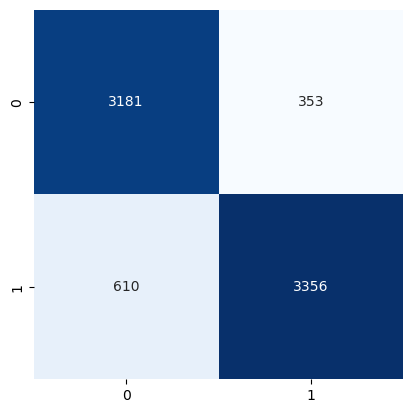

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
matrix_confusion = confusion_matrix([x.data.cpu().numpy() for x in y_pred], [x.data.cpu().numpy() for x in y_true])
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
